In [1]:
import pandas as pd

df = pd.read_json("dataset/df_clean.json", lines=True)  
print(df.shape)
print(df.head())


(37120, 37)
                               name  \
0                             Parsr   
1  Yet-Another-EfficientDet-Pytorch   
2                               nit   
3                           new.css   
4                      golang-notes   

                                         description  stargazerCount  \
0  Transforms PDF, Documents and Images into Enri...            5755   
1  The pytorch re-implement of the official effic...            5200   
2                                 Git of Web3 assets            4452   
3  A classless CSS framework to write modern webs...            3946   
4                     Go source code analysis(zh-cn)            3941   

   forkCount            createdAt            updatedAt             pushedAt  \
0        306  2019-08-05T12:43:53  2024-09-01T17:24:35  2023-12-03T13:27:21   
1       1268  2020-04-06T03:27:06  2024-08-22T08:04:26  2021-10-24T02:13:31   
2          8  2022-04-20T08:21:14  2024-08-08T16:18:20  2024-07-29T14:17:11   
3   

In [2]:
# STEP 1 — Robust JSON peek & sample load (single cell)

import os, json, itertools
import pandas as pd

# --- 0) Config ---
PATH = "dataset/df_clean.json"   # <- your file path
EXPECTED_ROWS = 37000            # for memory projection only

assert os.path.exists(PATH), f"File not found: {PATH}"

# --- 1) File info ---
size_bytes = os.path.getsize(PATH)
size_mb = size_bytes / (1024**2)
print(f"[INFO] File size: {size_mb:.2f} MB")

# --- 2) Quick raw peek (first 5 lines) ---
with open(PATH, 'r', encoding='utf-8') as f:
    head_lines = [line.rstrip('\n') for line in itertools.islice(f, 5)]
print("\n[PEEK] First lines (truncated to 160 chars):")
for i, ln in enumerate(head_lines, 1):
    print(f"{i:02d}: {ln[:160]}{'...' if len(ln)>160 else ''}")

# --- 3) Heuristic: JSON Lines vs JSON array ---
first_non_ws_char = None
with open(PATH, 'r', encoding='utf-8') as f:
    while True:
        ch = f.read(1)
        if not ch or not ch.isspace():
            first_non_ws_char = ch
            break

is_jsonl = (first_non_ws_char == '{')   # typical for JSONL: one object per line
is_array = (first_non_ws_char == '[')   # typical for a JSON array

print(f"\n[DETECT] Format: {'JSON Lines' if is_jsonl else 'JSON array' if is_array else 'Unknown'}")

# --- 4) Sample load (safe) ---
if is_jsonl:
    # Read a first chunk only; fast schema check; avoids full memory load
    chunk_iter = pd.read_json(PATH, lines=True, chunksize=20000)
    df_sample = next(chunk_iter)
else:
    # Likely a single JSON array or dict; ok for ~37k rows
    with open(PATH, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if isinstance(data, list):
        df_sample = pd.json_normalize(data)
    elif isinstance(data, dict):
        # Try to find the first list-like key if present
        list_keys = [k for k, v in data.items() if isinstance(v, list)]
        key = list_keys[0] if list_keys else None
        base = data if key is None else data[key]
        df_sample = pd.json_normalize(base)
    else:
        raise ValueError("Unexpected JSON structure: not a list or dict.")

print(f"\n[SAMPLE] shape={df_sample.shape}")
print("\n[SAMPLE HEAD — transposed for readability]\n", df_sample.head(3).T)

# --- 5) Memory projection for full dataset ---
mem_sample = df_sample.memory_usage(deep=True).sum()
rows = len(df_sample)
if rows > 0:
    bpr = mem_sample / rows
    est_total_bytes = bpr * (EXPECTED_ROWS or rows)
    print(f"\n[MEM] ~{bpr/1024:.1f} KB per row (sample)")
    print(f"[MEM] Projected for {EXPECTED_ROWS:,} rows: ~{est_total_bytes/(1024**2):.1f} MB")

# --- 6) Persist columns for manual review (optional) ---
df_sample.columns.to_series().to_csv("schema_columns.csv", index=False)
print("\n[OK] Saved column names to schema_columns.csv")


[INFO] File size: 34.51 MB

[PEEK] First lines (truncated to 160 chars):
01: {"name":"Parsr","description":"Transforms PDF, Documents and Images into Enriched Structured Data","stargazerCount":5755,"forkCount":306,"createdAt":"2019-08-05...
02: {"name":"Yet-Another-EfficientDet-Pytorch","description":"The pytorch re-implement of the official efficientdet with SOTA performance in real time and pretraine...
03: {"name":"nit","description":"Git of Web3 assets","stargazerCount":4452,"forkCount":8,"createdAt":"2022-04-20T08:21:14","updatedAt":"2024-08-08T16:18:20","pushed...
04: {"name":"new.css","description":"A classless CSS framework to write modern websites using only HTML.","stargazerCount":3946,"forkCount":127,"createdAt":"2020-05...
05: {"name":"golang-notes","description":"Go source code analysis(zh-cn)","stargazerCount":3941,"forkCount":667,"createdAt":"2018-04-04T05:21:51","updatedAt":"2024-...

[DETECT] Format: JSON Lines

[SAMPLE] shape=(20000, 37)

[SAMPLE HEAD — transposed for

In [3]:
# STEP 2.1 — Convert datetime columns only

import pandas as pd

df = pd.read_json("dataset/df_clean.json", lines=True)

for c in ['createdAt', 'updatedAt', 'pushedAt']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce', utc=True)

print(df[['name','createdAt','updatedAt','pushedAt']].head())
print(df.dtypes[['createdAt','updatedAt','pushedAt']])


                               name                 createdAt  \
0                             Parsr 2019-08-05 12:43:53+00:00   
1  Yet-Another-EfficientDet-Pytorch 2020-04-06 03:27:06+00:00   
2                               nit 2022-04-20 08:21:14+00:00   
3                           new.css 2020-05-03 03:18:57+00:00   
4                      golang-notes 2018-04-04 05:21:51+00:00   

                  updatedAt                  pushedAt  
0 2024-09-01 17:24:35+00:00 2023-12-03 13:27:21+00:00  
1 2024-08-22 08:04:26+00:00 2021-10-24 02:13:31+00:00  
2 2024-08-08 16:18:20+00:00 2024-07-29 14:17:11+00:00  
3 2024-09-01 17:29:23+00:00 2024-03-16 08:40:48+00:00  
4 2024-08-31 01:40:45+00:00 2022-07-18 09:30:00+00:00  
createdAt    datetime64[ns, UTC]
updatedAt    datetime64[ns, UTC]
pushedAt     datetime64[ns, UTC]
dtype: object


In [4]:
# STEP 2.2 — Create lastActivityAt as row-wise max of updatedAt & pushedAt

df['lastActivityAt'] = df[['updatedAt','pushedAt']].max(axis=1)

print(df[['name','createdAt','pushedAt','updatedAt','lastActivityAt']].head())


                               name                 createdAt  \
0                             Parsr 2019-08-05 12:43:53+00:00   
1  Yet-Another-EfficientDet-Pytorch 2020-04-06 03:27:06+00:00   
2                               nit 2022-04-20 08:21:14+00:00   
3                           new.css 2020-05-03 03:18:57+00:00   
4                      golang-notes 2018-04-04 05:21:51+00:00   

                   pushedAt                 updatedAt  \
0 2023-12-03 13:27:21+00:00 2024-09-01 17:24:35+00:00   
1 2021-10-24 02:13:31+00:00 2024-08-22 08:04:26+00:00   
2 2024-07-29 14:17:11+00:00 2024-08-08 16:18:20+00:00   
3 2024-03-16 08:40:48+00:00 2024-09-01 17:29:23+00:00   
4 2022-07-18 09:30:00+00:00 2024-08-31 01:40:45+00:00   

             lastActivityAt  
0 2024-09-01 17:24:35+00:00  
1 2024-08-22 08:04:26+00:00  
2 2024-08-08 16:18:20+00:00  
3 2024-09-01 17:29:23+00:00  
4 2024-08-31 01:40:45+00:00  


In [5]:
# STEP 2.3 — Build duration_days (float, in days)
import numpy as np

df['duration_days'] = (df['lastActivityAt'] - df['createdAt']).dt.total_seconds() / (24*3600)

# تبدیل به float32 برای صرفه‌جویی در حافظه
df['duration_days'] = df['duration_days'].astype('float32')

# مقدارهای منفی → NaN
neg_count = (df['duration_days'] < 0).sum()
df.loc[df['duration_days'] < 0, 'duration_days'] = np.nan

print(f"[INFO] Negative durations fixed to NaN: {neg_count}")
print(df[['name','createdAt','lastActivityAt','duration_days']].head())


[INFO] Negative durations fixed to NaN: 0
                               name                 createdAt  \
0                             Parsr 2019-08-05 12:43:53+00:00   
1  Yet-Another-EfficientDet-Pytorch 2020-04-06 03:27:06+00:00   
2                               nit 2022-04-20 08:21:14+00:00   
3                           new.css 2020-05-03 03:18:57+00:00   
4                      golang-notes 2018-04-04 05:21:51+00:00   

             lastActivityAt  duration_days  
0 2024-09-01 17:24:35+00:00    1854.194946  
1 2024-08-22 08:04:26+00:00    1599.192627  
2 2024-08-08 16:18:20+00:00     841.331299  
3 2024-09-01 17:29:23+00:00    1582.590576  
4 2024-08-31 01:40:45+00:00    2340.846436  


count    37120.000000
mean      1617.811401
std        567.743591
min          8.581482
25%       1260.153534
50%       1726.833496
75%       2077.066467
90%       2275.533984
95%       2345.779651
99%       2409.718281
max       2446.584473
Name: duration_days, dtype: float64


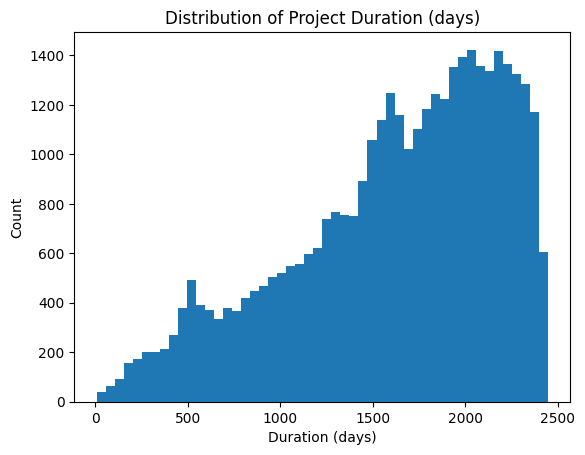

In [6]:
# STEP 2.4 — Explore distribution of duration_days

import matplotlib.pyplot as plt

# خلاصه آماری
print(df['duration_days'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]))

# هیستوگرام ساده
plt.hist(df['duration_days'].dropna(), bins=50)
plt.xlabel("Duration (days)")
plt.ylabel("Count")
plt.title("Distribution of Project Duration (days)")
plt.show()


In [7]:
# STEP 3.1 — Candidate feature selection & NaN check (fixed)

# Map possible names to simplified versions
rename_map = {}
if 'primaryLanguage.name' in df.columns:
    rename_map['primaryLanguage.name'] = 'primaryLanguage'
if 'licenseInfo.name' in df.columns:
    rename_map['licenseInfo.name'] = 'license'

df = df.rename(columns=rename_map)

# Candidate numeric features
num_features = [
    'stargazerCount','forkCount','issues','pullRequests',
    'contributors','watchers','diskUsage'
]

# Candidate categorical features
cat_features = ['primaryLanguage','license']

# Candidate boolean features
bool_features = [
    'isFork','isPrivate','isArchived',
    'hasIssuesEnabled','hasWikiEnabled','hasProjectsEnabled'
]

# Combine into one list
candidate_features = num_features + cat_features + bool_features

# Subset dataframe safely (only existing columns)
existing_features = [c for c in candidate_features if c in df.columns]
df_feat = df[existing_features + ['duration_days']].copy()

# Check missing values
print("[NaN count per column]")
print(df_feat.isna().sum().sort_values(ascending=False))

# Quick info
print("\n[Data types]")
print(df_feat.dtypes)

# Preview
print("\n[Sample rows]")
print(df_feat.head(5))


[NaN count per column]
license               8795
stargazerCount           0
forkCount                0
issues                   0
pullRequests             0
contributors             0
watchers                 0
diskUsage                0
primaryLanguage          0
isFork                   0
isPrivate                0
isArchived               0
hasIssuesEnabled         0
hasWikiEnabled           0
hasProjectsEnabled       0
duration_days            0
dtype: int64

[Data types]
stargazerCount          int64
forkCount               int64
issues                  int64
pullRequests            int64
contributors            int64
watchers                int64
diskUsage               int64
primaryLanguage        object
license                object
isFork                   bool
isPrivate                bool
isArchived               bool
hasIssuesEnabled         bool
hasWikiEnabled           bool
hasProjectsEnabled       bool
duration_days         float32
dtype: object

[Sample rows]
   starga

In [8]:
# STEP 3.2 — Prepare features for ML

df_ready = df_feat.copy()

# 1. Boolean → int (0/1)
bool_cols = df_ready.select_dtypes(include=['bool']).columns
df_ready[bool_cols] = df_ready[bool_cols].astype(int)

# 2. Handle categorical
# Fill NaN in license
df_ready['license'] = df_ready['license'].fillna("Unknown")

# Convert to category type (efficient for encoding later)
df_ready['primaryLanguage'] = df_ready['primaryLanguage'].astype('category')
df_ready['license'] = df_ready['license'].astype('category')

# 3. Quick check
print(df_ready.dtypes)
print("\nUnique primaryLanguage:", df_ready['primaryLanguage'].nunique())
print("Unique license:", df_ready['license'].nunique())
print("\n[Sample rows]\n", df_ready.head(3))


stargazerCount           int64
forkCount                int64
issues                   int64
pullRequests             int64
contributors             int64
watchers                 int64
diskUsage                int64
primaryLanguage       category
license               category
isFork                   int64
isPrivate                int64
isArchived               int64
hasIssuesEnabled         int64
hasWikiEnabled           int64
hasProjectsEnabled       int64
duration_days          float32
dtype: object

Unique primaryLanguage: 205
Unique license: 39

[Sample rows]
    stargazerCount  forkCount  issues  pullRequests  contributors  watchers  \
0            5755        306     163           504            22        81   
1            5200       1268     716            37            15       108   
2            4452          8      26            13             4        12   

   diskUsage   primaryLanguage                                 license  \
0      55148        JavaScript         

In [9]:
# STEP 3.3 — Encode categorical features

df_model = df_ready.copy()

# --- License: One-Hot Encoding
df_model = pd.get_dummies(df_model, columns=['license'], prefix='lic')

# --- PrimaryLanguage: Top-10 One-Hot + "Other"
top_langs = df_model['primaryLanguage'].value_counts().nlargest(10).index
df_model['primaryLanguage'] = df_model['primaryLanguage'].apply(
    lambda x: x if x in top_langs else "Other"
)
df_model = pd.get_dummies(df_model, columns=['primaryLanguage'], prefix='lang')

print("[Shape after encoding]", df_model.shape)
print("[Columns sample]", df_model.columns[:20])
print("\n[Sample rows]\n", df_model.head(3))


[Shape after encoding] (37120, 64)
[Columns sample] Index(['stargazerCount', 'forkCount', 'issues', 'pullRequests', 'contributors',
       'watchers', 'diskUsage', 'isFork', 'isPrivate', 'isArchived',
       'hasIssuesEnabled', 'hasWikiEnabled', 'hasProjectsEnabled',
       'duration_days', 'lic_Academic Free License v3.0',
       'lic_Apache License 2.0', 'lic_Artistic License 2.0',
       'lic_BSD 2-Clause "Simplified" License',
       'lic_BSD 3-Clause "New" or "Revised" License',
       'lic_BSD 3-Clause Clear License'],
      dtype='object')

[Sample rows]
    stargazerCount  forkCount  issues  pullRequests  contributors  watchers  \
0            5755        306     163           504            22        81   
1            5200       1268     716            37            15       108   
2            4452          8      26            13             4        12   

   diskUsage  isFork  isPrivate  isArchived  ...  lang_C#  lang_C++  lang_Go  \
0      55148       0          0       

In [10]:
# STEP 4.1 — Baseline Linear Regression with 5-Fold CV

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

# Features (X) and target (y)
X = df_model.drop(columns=['duration_days'])
y = df_model['duration_days']

# Define model
linreg = LinearRegression()

# Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics
r2_scores = cross_val_score(linreg, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(linreg, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(linreg, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[Baseline Linear Regression]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")


[Baseline Linear Regression]
R²: 0.060 ± 0.011
MAE: 450.7 days
RMSE: 550.5 days


In [11]:
# STEP 4.2 — RandomForest Regressor with 5-Fold CV

'''from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# Features (X) and target (y)
X = df_model.drop(columns=['duration_days'])
y = df_model['duration_days']

# Define model (default hyperparams for baseline)
rf = RandomForestRegressor(
    n_estimators=200,      # تعداد درخت‌ها
    max_depth=None,        # عمق آزاد (بذاریم خودش یاد بگیره)
    min_samples_leaf=1,    # حداقل نمونه در هر برگ
    random_state=42,
    n_jobs=-1              # استفاده از همه CPU coreها
)

# Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics
r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(rf, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[RandomForest Regressor]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")'''



#save result for final test

'from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import cross_val_score, KFold\nfrom sklearn.metrics import make_scorer, mean_absolute_error\nimport numpy as np\n\n# Features (X) and target (y)\nX = df_model.drop(columns=[\'duration_days\'])\ny = df_model[\'duration_days\']\n\n# Define model (default hyperparams for baseline)\nrf = RandomForestRegressor(\n    n_estimators=200,      # تعداد درخت\u200cها\n    max_depth=None,        # عمق آزاد (بذاریم خودش یاد بگیره)\n    min_samples_leaf=1,    # حداقل نمونه در هر برگ\n    random_state=42,\n    n_jobs=-1              # استفاده از همه CPU coreها\n)\n\n# Define CV strategy\ncv = KFold(n_splits=5, shuffle=True, random_state=42)\n\n# Metrics\nr2_scores = cross_val_score(rf, X, y, cv=cv, scoring=\'r2\')\nmae_scores = cross_val_score(rf, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))\nrmse_scores = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring=\'neg_mean_squared_error\'))\n\nprint("[RandomForest Regr

In [12]:
# STEP 4.2 — RandomForest Regressor (lighter for Mac 2015)

rf = RandomForestRegressor(
    n_estimators=50,    # کمتر برای سرعت بیشتر
    max_depth=15,       # عمق محدود
    random_state=42,
    n_jobs=-1
)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(rf, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[RandomForest Regressor — Light Version]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")


NameError: name 'RandomForestRegressor' is not defined

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

X = df_model.drop(columns=['duration_days'])
y = df_model['duration_days']

xgb = XGBRegressor(
    n_estimators=100,    # تعداد درخت‌ها
    max_depth=6,         # عمق محدود
    learning_rate=0.1,   # نرخ یادگیری
    subsample=0.8,       # برای سرعت بیشتر
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

r2_scores = cross_val_score(xgb, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(xgb, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(xgb, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[XGBoost Regressor — Light Version]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")


[XGBoost Regressor — Light Version]
R²: 0.275 ± 0.004
MAE: 389.7 days
RMSE: 483.3 days


In [ ]:
# STEP 5 — Feature Engineering: ratios & rates

df_fe = df_model.copy()

# 1. Avoid division by zero → replace 0 contributors or duration_days with NaN
df_fe['contributors'] = df_fe['contributors'].replace(0, np.nan)
df_fe['duration_days'] = df_fe['duration_days'].replace(0, np.nan)

# 2. Team productivity ratios
df_fe['issues_per_contributor'] = df_fe['issues'] / df_fe['contributors']
df_fe['prs_per_contributor'] = df_fe['pullRequests'] / df_fe['contributors']

# 3. Popularity normalized by time
df_fe['stars_per_day'] = df_fe['stargazerCount'] / df_fe['duration_days']
df_fe['forks_per_day'] = df_fe['forkCount'] / df_fe['duration_days']

# 4. Overall activity score
df_fe['activity_score'] = (df_fe['issues'] + df_fe['pullRequests'] + df_fe['forkCount']) / df_fe['duration_days']

# 5. Replace any inf or NaN produced during division with 0 (safe default)
df_fe = df_fe.replace([np.inf, -np.inf], np.nan).fillna(0)

print("[Shape after Feature Engineering]", df_fe.shape)
print("[New Features Sample]")
print(df_fe[['issues_per_contributor','prs_per_contributor','stars_per_day','forks_per_day','activity_score']].head(5))


[Shape after Feature Engineering] (37120, 69)
[New Features Sample]
   issues_per_contributor  prs_per_contributor  stars_per_day  forks_per_day  \
0                7.409091            22.909091       3.103773       0.165031   
1               47.733333             2.466667       3.251641       0.792900   
2                6.500000             3.250000       5.291613       0.009509   
3                3.636364             3.909091       2.493380       0.080248   
4                2.300000             3.900000       1.683579       0.284940   

   activity_score  
0        0.524756  
1        1.263763  
2        0.055864  
3        0.132694  
4        0.311426  


In [ ]:
# STEP 6 — XGBoost with engineered features

X = df_fe.drop(columns=['duration_days'])
y = df_fe['duration_days']

xgb_fe = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

r2_scores = cross_val_score(xgb_fe, X, y, cv=cv, scoring='r2')
mae_scores = cross_val_score(xgb_fe, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
rmse_scores = np.sqrt(-cross_val_score(xgb_fe, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("[XGBoost with Feature Engineering]")
print(f"R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"MAE: {mae_scores.mean():.1f} days")
print(f"RMSE: {rmse_scores.mean():.1f} days")


[XGBoost with Feature Engineering]
R²: 0.993 ± 0.000
MAE: 33.1 days
RMSE: 48.6 days


In [ ]:
# STEP 5 — Feature Engineering (fixed, no leakage)

df_fe_fixed = df_model.copy()

# جلوگیری از تقسیم بر صفر
df_fe_fixed['contributors'] = df_fe_fixed['contributors'].replace(0, np.nan)

# فیچرهای امن (بدون استفاده از duration_days)
df_fe_fixed['issues_per_contributor'] = df_fe_fixed['issues'] / df_fe_fixed['contributors']
df_fe_fixed['prs_per_contributor'] = df_fe_fixed['pullRequests'] / df_fe_fixed['contributors']

# جایگزینی NaN/inf با 0
df_fe_fixed = df_fe_fixed.replace([np.inf, -np.inf], np.nan).fillna(0)

print("[Shape after safe Feature Engineering]", df_fe_fixed.shape)
print("[Sample of safe features]")
print(df_fe_fixed[['issues_per_contributor','prs_per_contributor']].head(5))


[Shape after safe Feature Engineering] (37120, 66)
[Sample of safe features]
   issues_per_contributor  prs_per_contributor
0                7.409091            22.909091
1               47.733333             2.466667
2                6.500000             3.250000
3                3.636364             3.909091
4                2.300000             3.900000


In [ ]:
# STEP 6 — Compare Linear, RF, XGB on df_fe_fixed

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# Features & target
X = df_fe_fixed.drop(columns=['duration_days'])
y = df_fe_fixed['duration_days']

cv = KFold(n_splits=3, shuffle=True, random_state=42)

results = {}

# --- Linear Regression ---
linreg = LinearRegression()
results['Linear'] = {
    "R2": cross_val_score(linreg, X, y, cv=cv, scoring='r2').mean(),
    "MAE": cross_val_score(linreg, X, y, cv=cv, scoring=make_scorer(mean_absolute_error)).mean(),
    "RMSE": np.sqrt(-cross_val_score(linreg, X, y, cv=cv, scoring='neg_mean_squared_error')).mean()
}

# --- RandomForest (light) ---
rf = RandomForestRegressor(
    n_estimators=50, max_depth=15,
    random_state=42, n_jobs=-1
)
results['RandomForest'] = {
    "R2": cross_val_score(rf, X, y, cv=cv, scoring='r2').mean(),
    "MAE": cross_val_score(rf, X, y, cv=cv, scoring=make_scorer(mean_absolute_error)).mean(),
    "RMSE": np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error')).mean()
}

# --- XGBoost (light) ---
xgb = XGBRegressor(
    n_estimators=100, max_depth=6,
    learning_rate=0.1, subsample=0.8,
    colsample_bytree=0.8, random_state=42, n_jobs=-1
)
results['XGBoost'] = {
    "R2": cross_val_score(xgb, X, y, cv=cv, scoring='r2').mean(),
    "MAE": cross_val_score(xgb, X, y, cv=cv, scoring=make_scorer(mean_absolute_error)).mean(),
    "RMSE": np.sqrt(-cross_val_score(xgb, X, y, cv=cv, scoring='neg_mean_squared_error')).mean()
}

# --- Print results ---
for model, metrics in results.items():
    print(f"\n[{model}]")
    print(f"R²: {metrics['R2']:.3f}")
    print(f"MAE: {metrics['MAE']:.1f} days")
    print(f"RMSE: {metrics['RMSE']:.1f} days")



[Linear]
R²: 0.062
MAE: 450.5 days
RMSE: 549.9 days

[RandomForest]
R²: 0.249
MAE: 396.1 days
RMSE: 491.9 days

[XGBoost]
R²: 0.273
MAE: 390.1 days
RMSE: 484.0 days


In [ ]:
# Inspect columns and types
for col in df.columns:
    print(f"\n--- {col} ---")
    print("dtype:", type(df[col].iloc[0]))
    print("sample:", df[col].iloc[0])



--- name ---
dtype: <class 'str'>
sample: Parsr

--- description ---
dtype: <class 'str'>
sample: Transforms PDF, Documents and Images into Enriched Structured Data

--- stargazerCount ---
dtype: <class 'numpy.int64'>
sample: 5755

--- forkCount ---
dtype: <class 'numpy.int64'>
sample: 306

--- createdAt ---
dtype: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
sample: 2019-08-05 12:43:53+00:00

--- updatedAt ---
dtype: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
sample: 2024-09-01 17:24:35+00:00

--- pushedAt ---
dtype: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
sample: 2023-12-03 13:27:21+00:00

--- diskUsage ---
dtype: <class 'numpy.int64'>
sample: 55148

--- isArchived ---
dtype: <class 'numpy.bool_'>
sample: False

--- isEmpty ---
dtype: <class 'numpy.bool_'>
sample: False

--- isFork ---
dtype: <class 'numpy.bool_'>
sample: False

--- isInOrganization ---
dtype: <class 'numpy.bool_'>
sample: True

--- isPrivate ---
dtype: <class 'numpy.bool_'>
sample: False

-

### Going into the unsupervised learning

In [13]:
# STEP 1: Build a clean feature matrix for unsupervised clustering
# - Loads a JSONL if path is given; otherwise uses an existing df in memory
# - Selects safe features (NO leakage: excludes duration_days or any target-like fields)
# - Applies log1p to heavy-tailed counts, then StandardScaler
# - Outputs: X_scaled (ndarray), feature_names (list), df_used (DataFrame subset)

import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ---- Configuration ----
# If your DataFrame already exists (e.g., df or df_clean2), set USE_EXISTING_DF=True.
USE_EXISTING_DF = True

# If you want to load from disk instead, set USE_EXISTING_DF=False and set DATA_PATH:
DATA_PATH = "dataset/df_clean2.json"  # JSON Lines: one record per line

# Core feature set (safe; adjust if any are missing in your file)
COUNT_FEATS = [
    "stargazerCount","forkCount","issues","pullRequests","contributors",
    "watchers","diskUsage","language_count"
]
BOOL_FEATS = [
    "isFork","isArchived","hasIssuesEnabled","hasWikiEnabled",
    "hasProjectsEnabled","isPrivate"
]

# ---- Load DataFrame ----
df_used = None
if USE_EXISTING_DF:
    # Try common variable names in the current notebook state
    for cand in ["df_clean2","df_clean","df"]:
        if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
            df_used = globals()[cand].copy()
            break
    if df_used is None:
        raise ValueError("No existing DataFrame found (df_clean2/df_clean/df). "
                         "Set USE_EXISTING_DF=False to load from disk.")
else:
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"DATA_PATH not found: {DATA_PATH}")
    # Try JSON Lines first; fallback to standard JSON
    try:
        df_used = pd.read_json(DATA_PATH, lines=True)
    except ValueError:
        df_used = pd.read_json(DATA_PATH)

# ---- Minimal sanitation ----
# Ensure missing columns are created as zeros (so pipeline doesn't break)
for col in COUNT_FEATS + BOOL_FEATS:
    if col not in df_used.columns:
        df_used[col] = 0

# Coerce dtypes
for c in COUNT_FEATS:
    df_used[c] = pd.to_numeric(df_used[c], errors="coerce").fillna(0)

for c in BOOL_FEATS:
    # Convert truthy/falsey to 0/1
    df_used[c] = df_used[c].astype("bool").astype("int8")

# Drop blatant non-finite
df_used.replace([np.inf, -np.inf], np.nan, inplace=True)
df_used.dropna(subset=COUNT_FEATS + BOOL_FEATS, inplace=True)

# ---- Transformations ----
# log1p on heavy-tailed counts
df_trans = df_used.copy()
for c in COUNT_FEATS:
    df_trans[c] = np.log1p(df_trans[c].astype(float))

# Build final matrix
feature_names = COUNT_FEATS + BOOL_FEATS
X = df_trans[feature_names].to_numpy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Quick diagnostics ----
n_rows = X_scaled.shape[0]
n_cols = X_scaled.shape[1]
nan_count = np.isnan(X_scaled).sum()

print(f"[OK] Feature matrix built: shape={X_scaled.shape} (rows={n_rows}, cols={n_cols})")
print(f"NaNs in X_scaled: {nan_count}")
print("Features:", feature_names)


[OK] Feature matrix built: shape=(37120, 14) (rows=37120, cols=14)
NaNs in X_scaled: 0
Features: ['stargazerCount', 'forkCount', 'issues', 'pullRequests', 'contributors', 'watchers', 'diskUsage', 'language_count', 'isFork', 'isArchived', 'hasIssuesEnabled', 'hasWikiEnabled', 'hasProjectsEnabled', 'isPrivate']


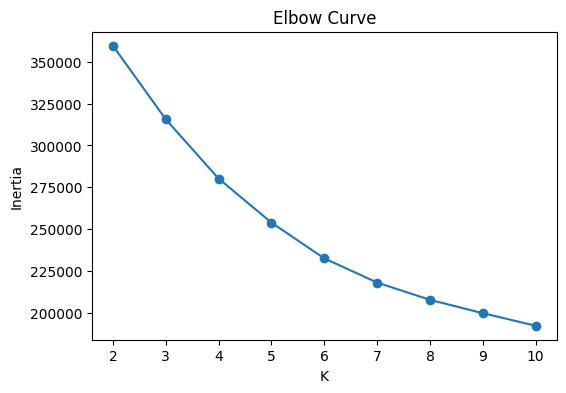

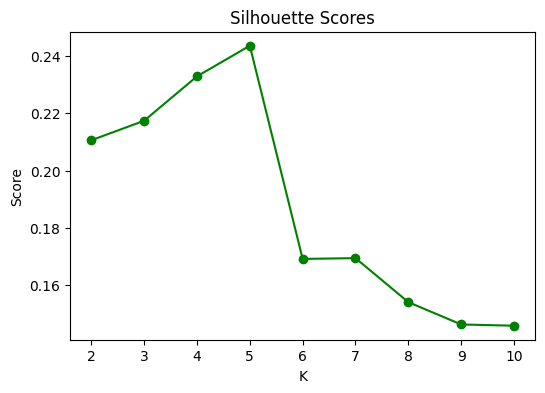

K=2: inertia=359607.9, silhouette=0.211
K=3: inertia=315591.9, silhouette=0.217
K=4: inertia=280153.2, silhouette=0.233
K=5: inertia=253844.8, silhouette=0.244
K=6: inertia=232445.3, silhouette=0.169
K=7: inertia=217996.3, silhouette=0.169
K=8: inertia=207672.2, silhouette=0.154
K=9: inertia=199668.5, silhouette=0.146
K=10: inertia=192180.2, silhouette=0.146


In [14]:
# STEP 2: Choose optimal K using Elbow & Silhouette
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K_range = range(2, 11)  # try 2 to 10 clusters
inertias = []
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels, sample_size=5000, random_state=42)
    sil_scores.append(sil)

# Plot Elbow curve
plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Curve")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

# Plot Silhouette scores
plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, marker='o', color='green')
plt.title("Silhouette Scores")
plt.xlabel("K")
plt.ylabel("Score")
plt.show()

for k, inertia, sil in zip(K_range, inertias, sil_scores):
    print(f"K={k}: inertia={inertia:.1f}, silhouette={sil:.3f}")
